In [1]:
import tensorflow as tf
import numpy as np
import random
import os
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
import random
import cv2
import pdb

In [2]:
label={"bald_uakari":0,"black_headed_night_monkey":1,"common_squirrel_monkey":2,"japanese_macaque":3,"mantled_howler":4,
       "nilgiri_langur":5,"patas_monkey":6,"pygmy_marmoset":7,"silvery_marmoset":8, "white_headed_capuchin":9}

train_img = []
test_img = []
val_img = []
t = []
y = []
k=list(label.keys())

In [3]:
k[label["bald_uakari"]]

'bald_uakari'

In [4]:
x=glob("sample/*/*.jpg")
x[0].split('\\')[-2]
x[0]

'sample\\bald_uakari\\12961458824_14a6951c26_w.jpg'

In [5]:
for i in range(10):
    t={0:glob('sample/bald_uakari/*.jpg'),
       1:glob('sample/black_headed_night_monkey/*.jpg'),
       2:glob('sample/common_squirrel_monkey/*.jpg'),
       3:glob('sample/japanese_macaque/*.jpg'),
       4:glob('sample/mantled_howler/*.jpg'),
       5:glob('sample/nilgiri_langur/*.jpg'),
       6:glob('sample/patas_monkey/*.jpg'),
       7:glob('sample/pygmy_marmoset/*.jpg'),
       8:glob('sample/silvery_marmoset/*.jpg'),
       9:glob('sample/white_headed_capuchin/*.jpg')}.get(i)
    
    lent = int(len(t)*0.8)

    for j in range(lent):
        train_img.append([cv2.resize(cv2.imread(t[0], cv2.IMREAD_COLOR), dsize=(128, 128), interpolation=cv2.INTER_AREA), 
                      label[t[0].split('\\')[-2].split('/')[-1]]])
        train_img.append([cv2.resize(cv2.flip(cv2.imread(t[0], 1), cv2.IMREAD_COLOR), dsize=(128, 128), interpolation=cv2.INTER_AREA), 
                      label[t[0].split('\\')[-2].split('/')[-1]]])
        t.pop(0)

    lent = int(len(t)*0.5)
    for j in range(lent):
        val_img.append([cv2.resize(cv2.imread(t[0], cv2.IMREAD_COLOR), dsize=(128, 128), interpolation=cv2.INTER_AREA), 
                     label[t[0].split('\\')[-2].split('/')[-1]]])
        t.pop(0)
        
    lent = len(t)
    for j in range(lent):
        test_img.append([cv2.resize(cv2.imread(t[0], cv2.IMREAD_COLOR), dsize=(128, 128), interpolation=cv2.INTER_AREA), 
                     label[t[0].split('\\')[-2].split('/')[-1]]])
        t.pop(0)
        
    #test_img.append(cv2.flip(test_img[-1], 1))
    
    print (i, " done")


0  done
1  done
2  done
3  done
4  done
5  done
6  done
7  done
8  done
9  done


In [6]:
len(train_img)

11326

In [7]:
len(test_img)

712

In [8]:
random.shuffle(train_img)
random.shuffle(test_img)
random.shuffle(val_img)

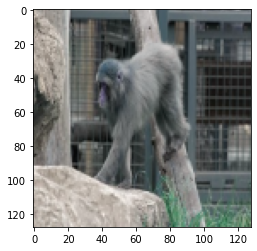

In [9]:
plt.imshow(train_img[10][0])

In [10]:
k[train_img[10][1]]

'japanese_macaque'

In [11]:
IMG_R = 128
IMG_C = 128
IMG_CH = 3

num_class = 10


In [12]:
with tf.Graph().as_default() as tfgp:
    X = tf.placeholder(tf.float32, [None, IMG_R, IMG_C, IMG_CH])
    Y = tf.placeholder(tf.int32, [None])

    with tf.variable_scope('CNN'):
        
        layer = tf.layers.conv2d(X, 48, 5, (2, 2), padding='same', activation=tf.nn.relu)
        layer = tf.layers.max_pooling2d(layer, (2, 2), (2, 2))
        layer = tf.layers.conv2d(layer, 128, 3, (1, 1), padding='same', activation=tf.nn.relu)        
        layer = tf.layers.max_pooling2d(layer, (2, 2), (2, 2))
        layer = tf.layers.conv2d(layer, 128, 3, (1, 1), padding='same', activation=tf.nn.relu)
        layer = tf.layers.conv2d(layer, 128, 3, (1, 1), padding='same', activation=tf.nn.relu)
        layer = tf.layers.max_pooling2d(layer, (3, 3), (2, 2))
        layer = tf.layers.flatten(layer)
        #layer = tf.layers.dense(layer, 1024)
        out = tf.layers.dense(layer, num_class)

    with tf.variable_scope('Loss'):
        loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=Y, logits=out))

    train = tf.train.AdamOptimizer(1e-3).minimize(loss)
    saver = tf.train.Saver()

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.


In [13]:
np.sum([np.product(var.shape) for var in tfgp.get_collection('trainable_variables')]).value

416970

In [14]:
train_image = []
train_label = []
test_image = []
test_label = []
val_image = []
val_label = []
val = []
tra = []
cnt=0

bs=128

In [16]:
lenval = len(val_img)
for i in range(lenval):
    val_image.append(val_img[i][0])
    val_label.append(val_img[i][1])

In [17]:
with tf.Session(graph=tfgp) as sess:
    sess.run(tf.global_variables_initializer())   
    for i in range(17000):
        #pdb.set_trace()
        for j in range(bs):
            train_image.append(train_img[0][0])
            train_label.append(train_img[0][1])
            train_img.append(train_img.pop(0))
            
        _, loss_t = sess.run([train, loss], feed_dict={X: train_image, Y: train_label})
        #print(i, l)
        tra.append(loss_t)

        for j in range(bs):
            train_image.pop(0)
            train_label.pop(0)
        
        
        if i%50==0:
            loss_t = sess.run(loss, feed_dict={X: val_image, Y: val_label})
            val.append(loss_t)
    
            print("[", cnt*50, "]", val[-1])
            cnt = cnt+1
    
    print("val: ", np.argmin(val))
    saver.save(sess, 'logs/model.ckpt', global_step=i + 1)

[ 0 ] 41.440926
[ 50 ] 1.9855571
[ 100 ] 1.5787272
[ 150 ] 1.4498001
[ 200 ] 1.3325735
[ 250 ] 1.2558607
[ 300 ] 1.194179
[ 350 ] 1.1875138
[ 400 ] 1.2107483
[ 450 ] 1.0496248
[ 500 ] 1.0469407
[ 550 ] 1.0491067
[ 600 ] 0.930277
[ 650 ] 1.0214423
[ 700 ] 1.0106218
[ 750 ] 0.9854014
[ 800 ] 1.0254611
[ 850 ] 1.0060611
[ 900 ] 1.0540532
[ 950 ] 1.0915205
[ 1000 ] 1.1675638
[ 1050 ] 1.1526897
[ 1100 ] 1.261082
[ 1150 ] 1.3033363
[ 1200 ] 1.2542685
[ 1250 ] 1.4121983
[ 1300 ] 1.2034556
[ 1350 ] 1.164812
[ 1400 ] 1.2552954
[ 1450 ] 1.2553365
[ 1500 ] 1.2883726
[ 1550 ] 1.2324235
[ 1600 ] 1.3480697
[ 1650 ] 1.3216906
[ 1700 ] 1.6340803
[ 1750 ] 1.5743544
[ 1800 ] 1.9020325
[ 1850 ] 1.3821936
[ 1900 ] 1.5035439
[ 1950 ] 1.6450431
[ 2000 ] 1.7474298
[ 2050 ] 1.8911372
[ 2100 ] 1.7683
[ 2150 ] 1.8411204
[ 2200 ] 1.7198352
[ 2250 ] 1.7068081
[ 2300 ] 2.0575416
[ 2350 ] 1.6775848
[ 2400 ] 1.6857849
[ 2450 ] 2.0669038
[ 2500 ] 1.7169182
[ 2550 ] 2.0236137
[ 2600 ] 1.586143
[ 2650 ] 1.9765551
[ 270

In [18]:
for i in range(int(len(tra))):
    print ("[%d]" %i, tra[i])

[0] 18.306732
[1] 32.198772
[2] 42.762283
[3] 59.49706
[4] 37.7987
[5] 23.854137
[6] 12.889717
[7] 7.423094
[8] 4.1287556
[9] 2.5766284
[10] 2.9980073
[11] 2.857338
[12] 2.448492
[13] 2.3477929
[14] 2.4650302
[15] 2.5214126
[16] 2.367751
[17] 2.2164688
[18] 2.2978196
[19] 2.3104556
[20] 2.3116956
[21] 2.2366936
[22] 2.3233132
[23] 2.258041
[24] 2.2349544
[25] 2.245963
[26] 2.2439313
[27] 2.182756
[28] 2.2060902
[29] 2.2884374
[30] 2.2033567
[31] 2.236341
[32] 2.2074122
[33] 2.2505302
[34] 2.1864138
[35] 2.2536788
[36] 2.1753664
[37] 2.141719
[38] 2.1734443
[39] 2.1801214
[40] 2.202236
[41] 2.1611493
[42] 2.1140723
[43] 2.1376703
[44] 2.0855727
[45] 2.0782235
[46] 2.1502626
[47] 2.097466
[48] 2.1117494
[49] 2.0692253
[50] 2.064738
[51] 2.0583713
[52] 2.0427542
[53] 2.027943
[54] 2.0088558
[55] 1.9675617
[56] 2.0837512
[57] 1.9958155
[58] 2.0301552
[59] 1.98228
[60] 1.9406614
[61] 2.1204474
[62] 1.9692495
[63] 1.858959
[64] 1.8573408
[65] 2.1097481
[66] 1.8467518
[67] 1.9234724
[68] 1.77

In [19]:
acc = 0
cnt_ = 1
lentest = len(test_img)


In [20]:
lentest

712

In [21]:
with tf.Session(graph=tfgp) as sess:
    sess.run(tf.global_variables_initializer())
    checkpoint = tf.train.latest_checkpoint('logs')
    if checkpoint:
        saver.restore(sess, checkpoint)
    for i in range(lentest):
        test_image.append(test_img[0][0])
        logit = sess.run(out, feed_dict={X: test_image})
        
        if np.argmax(logit[0]) == test_img[0][1]:
            acc += 1
            cv2.imwrite("./true/%s%d.jpg"%(k[test_img[0][1]],cnt_), test_img[0][0])
            cnt_ = cnt_+1
            
        else:
            print(logit[0], k[np.argmax(logit[0])], k[test_img[0][1]])
            cv2.imwrite("./false/%s%d.jpg"%(k[test_img[0][1]],cnt_), test_img[0][0])
            cnt_ = cnt_+1
            
            #cv2.imshow(k[np.argmax(logit[0])], test_image[0])
            #cv2.waitKey(0)
            #cv2.destroyAllWindows()

        test_img.append(test_img.pop(0))
        test_image.pop(0)

    print(acc / lentest)

INFO:tensorflow:Restoring parameters from logs\model.ckpt-17000
[  77.87649   -81.49387   -33.503376  161.36015  -179.74948  -179.15628
 -117.722374 -167.43484    62.50182  -198.86554 ] japanese_macaque bald_uakari
[ -75.58247   -201.02124     30.576162   -11.2065935 -445.86456
 -207.17897     39.22726    -43.1661     123.78808     28.954235 ] silvery_marmoset japanese_macaque
[-110.69067   -57.366646   16.931517  -16.20693  -183.16663   -41.444527
   17.63579    20.271826  192.94037   -84.254814] silvery_marmoset patas_monkey
[-204.51747  -127.109406 -144.24214  -116.130806  158.81773    33.2417
 -225.39737   -73.55733    -9.156932   78.64374 ] mantled_howler nilgiri_langur
[-163.68633   -58.0141    -16.78121    47.11759   -39.30156   -90.15344
   26.58649    87.34142    15.950961  -67.39837 ] pygmy_marmoset silvery_marmoset
[ -93.61754    -65.704254    16.802923   -18.474543  -193.92317
   -4.2659645   78.306175   -18.134552   133.28574    -85.091385 ] silvery_marmoset patas_monkey
[